# Dogs vs Cat Redux

## In this tutorial, you will learn how generate and submit predictions to a Kaggle competiton

[Dogs vs. Cats Redux: Kernels Edition](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition)
    
    

To start you will need to download and unzip the competition data from Kaggle and ensure your directory structure looks like this
```
utils/
    vgg16.py
    utils.py
lesson1/
    redux.ipynb
    data/
        redux/
            train/
                cat.437.jpg
                dog.9924.jpg
                cat.1029.jpg
                dog.4374.jpg
            test/
                231.jpg
                325.jpg
                1235.jpg
                9923.jpg
```

You can download the data files from the competition page [here](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data) or you can download them from the command line using the [Kaggle CLI](https://github.com/floydwch/kaggle-cli).

You should launch your notebook inside the lesson1 directory
```
cd lesson1
jupyter notebook
```

In [6]:
#Verify we are in the lesson1 directory
%pwd

'C:\\Python\\AI'

In [1]:
#Create references to important directories we will use over and over
import os, sys
from importlib import reload
current_dir = os.getcwd()
LESSON_HOME_DIR = current_dir
DATA_HOME_DIR = current_dir+'/data/dogscats'

In [2]:
%cd $current_dir
#Allow relative imports to directories above lesson1/
sys.path.insert(1, os.path.join(sys.path[0], '..'))

#import modules
from utils import *
import vgg16
reload(vgg16)
from vgg16 import Vgg16

#Instantiate plotting tool
#In Jupyter notebooks, you will need to run this command before doing any plotting
%matplotlib inline

C:\Python\AI


Using TensorFlow backend.


## Action Plan
1. Create Validation and Sample sets
2. Rearrange image files into their respective directories 
3. Finetune and Train model
4. Generate predictions
5. Validate predictions
6. Submit predictions to Kaggle

## Create validation set and sample

In [66]:
#Create directories
%cd $DATA_HOME_DIR
%mkdir valid
%mkdir results
%mkdir -p sample/train
%mkdir -p sample/test
%mkdir -p sample/valid
%mkdir -p sample/results
%mkdir -p test/unknown

/home/ubuntu/workplace/deep_learning_course/lesson1/data/redux


In [67]:
%cd $DATA_HOME_DIR/train

/home/ubuntu/workplace/deep_learning_course/lesson1/data/redux/train


In [68]:
g = glob('*.jpg')
shuf = np.random.permutation(g)
for i in range(2000): os.rename(shuf[i], DATA_HOME_DIR+'/valid/' + shuf[i])

In [69]:
from shutil import copyfile

In [70]:
g = glob('*.jpg')
shuf = np.random.permutation(g)
for i in range(200): copyfile(shuf[i], DATA_HOME_DIR+'/sample/train/' + shuf[i])

In [71]:
%cd $DATA_HOME_DIR/valid

/home/ubuntu/workplace/deep_learning_course/lesson1/data/redux/valid


In [72]:
g = glob('*.jpg')
shuf = np.random.permutation(g)
for i in range(50): copyfile(shuf[i], DATA_HOME_DIR+'/sample/valid/' + shuf[i])

## Rearrange image files into their respective directories

In [73]:
#Divide cat/dog images into separate directories

%cd $DATA_HOME_DIR/sample/train
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

%cd $DATA_HOME_DIR/sample/valid
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

%cd $DATA_HOME_DIR/valid
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

%cd $DATA_HOME_DIR/train
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

/home/ubuntu/workplace/deep_learning_course/lesson1/data/redux/sample/train
/home/ubuntu/workplace/deep_learning_course/lesson1/data/redux/sample/valid
/home/ubuntu/workplace/deep_learning_course/lesson1/data/redux/valid
/home/ubuntu/workplace/deep_learning_course/lesson1/data/redux/train


In [74]:
# Create single 'unknown' class for test set
%cd $DATA_HOME_DIR/test
%mv *.jpg unknown/

/home/ubuntu/workplace/deep_learning_course/lesson1/data/redux/test


## Finetuning and Training

In [4]:
%cd $DATA_HOME_DIR

#Set path to sample/ path if desired
path = DATA_HOME_DIR + '/'
#path = DATA_HOME_DIR + '/sample/'
test_path = DATA_HOME_DIR + '/test/' #We use all the test data
results_path = DATA_HOME_DIR + '/results/'
train_path = path + '/train/'
valid_path = path + '/valid/'
model_path = path + '/models/'

C:\Python\AI\data\dogscats


In [13]:
#import Vgg16 helper class
vgg = Vgg16()

In [16]:
#Set constants. You can experiment with no_of_epochs to improve the model
batch_size=32
no_of_epochs=1

In [17]:
#Finetune the model
batches = vgg.get_batches(train_path, batch_size=batch_size)
val_batches = vgg.get_batches(valid_path, batch_size=batch_size)
vgg.finetune(batches)

#Not sure if we set this for all fits
vgg.model.optimizer.lr = 0.0001
coverage = 1

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [18]:
vgg.model.load_weights(results_path+'ft1.1.h5')

In [19]:
#Notice we are passing in the validation dataset to the fit() method
#For each epoch we test our model against the validation set
latest_weights_filename = None
for epoch in range(no_of_epochs):
    print(f"Running epoch: {epoch}")
    vgg.fit(batches, val_batches, nb_epoch=1, coverage=coverage)
#     latest_weights_filename = f'ft_lr{vgg.model.optimizer.lr}_cv{coverage}_{epoch}.h5'
#     vgg.model.save_weights(results_path+latest_weights_filename)
print(f"Completed {no_of_epochs} fit operations")

Running epoch: 0
Epoch 1/1
719/718 [==============================] - 738s - loss: 0.1201 - acc: 0.9783 - val_loss: 0.1057 - val_acc: 0.9820
Completed 1 fit operations


In [20]:
vgg.model.save_weights(results_path+'ft2.h5')

In [29]:
def onehot(x): return np.array(OneHotEncoder().fit_transform(x.reshape(-1,1)).todense())
val_data = load_array(model_path+'valid_data.bc')
val_labels = onehot(val_batches.classes)

In [30]:
vgg.model.evaluate(val_data, val_labels, batch_size=batch_size)

2000/2000 [==============================] - 67s    


[0.1114390561245142, 0.98199999999999998]

## Generate Predictions

Let's use our new model to make predictions on the test dataset

In [21]:
batches, preds = vgg.test(test_path, batch_size = batch_size)

Found 12500 images belonging to 1 classes.
391/390 [==============================] - 367s   


In [22]:
#For every image, vgg.test() generates two probabilities 
#based on how we've ordered the cats/dogs directories.
#It looks like column one is cats and column two is dogs
print(preds[:5])

filenames = batches.filenames
print(filenames[:5])

[[  2.3690e-13   1.0000e+00]
 [  1.0000e+00   4.9182e-17]
 [  1.0000e+00   3.7251e-10]
 [  6.0095e-19   1.0000e+00]
 [  8.0359e-11   1.0000e+00]]
['unknown\\1.jpg', 'unknown\\10.jpg', 'unknown\\100.jpg', 'unknown\\1000.jpg', 'unknown\\10000.jpg']


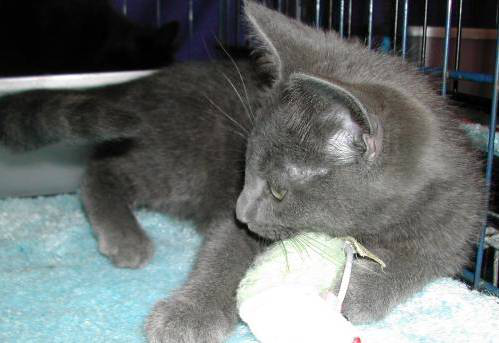

In [23]:
#You can verify the column ordering by viewing some images
from PIL import Image
Image.open(test_path + filenames[2])

In [26]:
#Save our test results arrays so we can use them again later
save_array(results_path + 'test_preds.dat', preds)
save_array(results_path + 'filenames.dat', filenames)

## Validate Predictions

Keras' *fit()* function conveniently shows us the value of the loss function, and the accuracy, after every epoch ("*epoch*" refers to one full run through all training examples). The most important metrics for us to look at are for the validation set, since we want to check for over-fitting. 

- **Tip**: with our first model we should try to overfit before we start worrying about how to reduce over-fitting - there's no point even thinking about regularization, data augmentation, etc if you're still under-fitting! (We'll be looking at these techniques shortly).

As well as looking at the overall metrics, it's also a good idea to look at examples of each of:
1. A few correct labels at random
2. A few incorrect labels at random
3. The most correct labels of each class (ie those with highest probability that are correct)
4. The most incorrect labels of each class (ie those with highest probability that are incorrect)
5. The most uncertain labels (ie those with probability closest to 0.5).

Let's see what we can learn from these examples. (In general, this is a particularly useful technique for debugging problems in the model. However, since this model is so simple, there may not be too much to learn at this stage.)

Calculate predictions on validation set, so we can find correct and incorrect examples:

In [28]:
val_batches, probs = vgg.test(valid_path, batch_size = batch_size)

Found 2000 images belonging to 2 classes.
63/62 [==============================] - 57s    


In [29]:
filenames = val_batches.filenames
expected_labels = val_batches.classes #0 or 1

#Round our predictions to 0/1 to generate labels
our_predictions = probs[:,0]
our_labels = np.round(1-our_predictions)

In [30]:
from keras.preprocessing import image

#Helper function to plot images by index in the validation set 
#Plots is a helper function in utils.py
def plots_idx(idx, titles=None):
    plots([image.load_img(valid_path + filenames[i]) for i in idx], titles=titles)
    
#Number of images to view for each visualization task
n_view = 4

Found 1964 correct labels


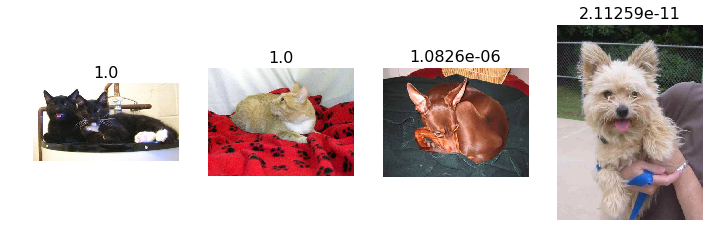

In [31]:
#1. A few correct labels at random
correct = np.where(our_labels==expected_labels)[0]
print(f"Found {len(correct)} correct labels")
idx = permutation(correct)[:n_view]
plots_idx(idx, our_predictions[idx])

Found 36 incorrect labels


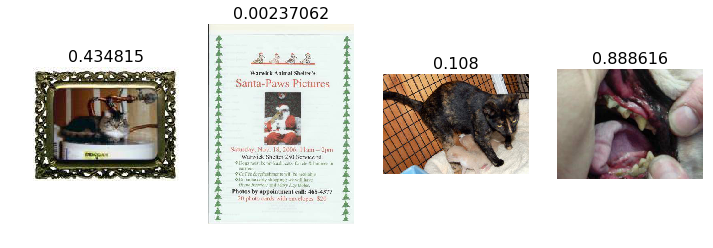

In [32]:
#2. A few incorrect labels at random
incorrect = np.where(our_labels!=expected_labels)[0]
print(f"Found {len(incorrect)} incorrect labels")
idx = permutation(incorrect)[:n_view]
plots_idx(idx, our_predictions[idx])

Found 980 confident correct cats labels


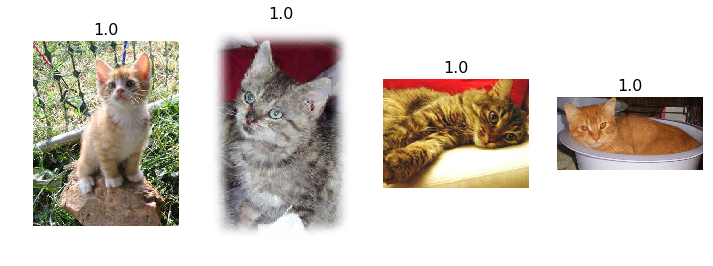

In [33]:
#3a. The images we most confident were cats, and are actually cats
correct_cats = np.where((our_labels==0) & (our_labels==expected_labels))[0]
print(f"Found {len(correct_cats)} confident correct cats labels")
most_correct_cats = np.argsort(our_predictions[correct_cats])[::-1][:n_view]
plots_idx(correct_cats[most_correct_cats], our_predictions[correct_cats][most_correct_cats])

Found 984 confident correct dogs labels


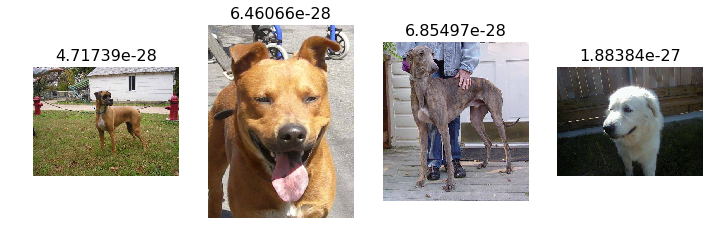

In [34]:
#3b. The images we most confident were dogs, and are actually dogs
correct_dogs = np.where((our_labels==1) & (our_labels==expected_labels))[0]
print(f"Found {len(correct_dogs)} confident correct dogs labels")
most_correct_dogs = np.argsort(our_predictions[correct_dogs])[:n_view]
plots_idx(correct_dogs[most_correct_dogs], our_predictions[correct_dogs][most_correct_dogs])

Found 16 incorrect cats


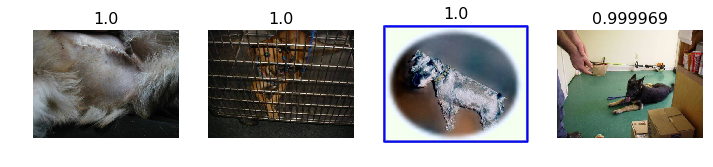

In [35]:
#4a. The images we were most confident were cats, but are actually dogs
incorrect_cats = np.where((our_labels==0) & (our_labels!=expected_labels))[0]
print(f"Found {len(incorrect_cats)} incorrect cats")
if len(incorrect_cats):
    most_incorrect_cats = np.argsort(our_predictions[incorrect_cats])[::-1][:n_view]
    plots_idx(incorrect_cats[most_incorrect_cats], our_predictions[incorrect_cats][most_incorrect_cats])

Found 20 incorrect dogs


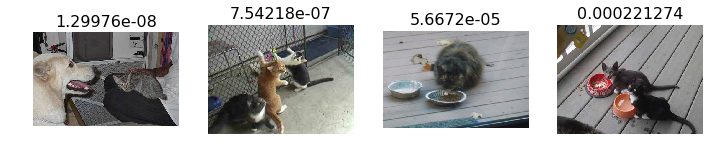

In [36]:
#4b. The images we were most confident were dogs, but are actually cats
incorrect_dogs = np.where((our_labels==1) & (our_labels!=expected_labels))[0]
print(f"Found {len(incorrect_dogs)} incorrect dogs")
if len(incorrect_dogs):
    most_incorrect_dogs = np.argsort(our_predictions[incorrect_dogs])[:n_view]
    plots_idx(incorrect_dogs[most_incorrect_dogs], our_predictions[incorrect_dogs][most_incorrect_dogs])

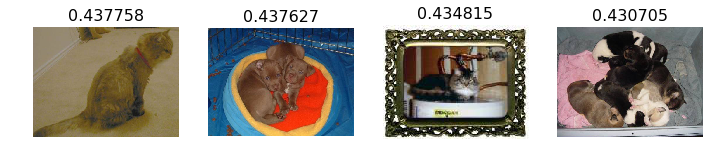

In [37]:
#5. The most uncertain labels (ie those with probability closest to 0.5).
most_uncertain = np.argsort(np.abs(our_predictions-0.5))
plots_idx(most_uncertain[:n_view], our_predictions[most_uncertain])

Perhaps the most common way to analyze the result of a classification model is to use a [confusion matrix](http://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/). Scikit-learn has a convenient function we can use for this purpose:

In [38]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, precision_recall_curve
cm = confusion_matrix(expected_labels, our_labels)

We can just print out the confusion matrix, or we can show a graphical view (which is mainly useful for dependents with a larger number of categories).

[[980  20]
 [ 16 984]]


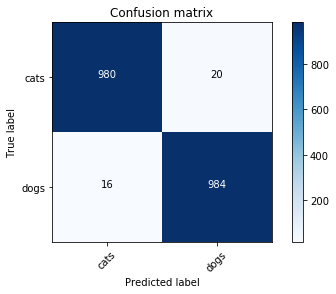

In [39]:
plot_confusion_matrix(cm, val_batches.class_indices)

Precision/Recall/Accuracy stats

In [40]:
print('precision:', precision_score(expected_labels, our_labels)) 
print('recall:', recall_score(expected_labels, our_labels)) 
print('accuracy:', accuracy_score(expected_labels, our_labels)) 

precision: 0.980079681275
recall: 0.984
accuracy: 0.982


## Submit Predictions to Kaggle!

Here's the format Kaggle requires for new submissions:
```
imageId,isDog
1242, .3984
3947, .1000
4539, .9082
2345, .0000
```

Kaggle wants the imageId followed by the probability of the image being a dog. Kaggle uses a metric called [Log Loss](http://wiki.fast.ai/index.php/Log_Loss) to evaluate your submission.

In [41]:
#Load our test predictions from file
preds = load_array(results_path + 'test_preds.dat')
filenames = load_array(results_path + 'filenames.dat')

In [42]:
#Grab the dog prediction column
isdog = preds[:,1]
print("Raw Predictions: " + str(isdog[:5]))
print("Mid Predictions: " + str(isdog[(isdog < .6) & (isdog > .4)]))
print("Edge Predictions: " + str(isdog[(isdog == 1) | (isdog == 0)]))

Raw Predictions: [  1.0000e+00   4.9182e-17   3.7251e-10   1.0000e+00   1.0000e+00]
Mid Predictions: [ 0.515   0.5811  0.4143  0.5012  0.5153  0.5634  0.5366  0.4685  0.562   0.5549  0.5526  0.5705
  0.4681  0.4736  0.4132  0.414   0.4553  0.5066  0.4114  0.5301  0.5331  0.4788  0.5325]
Edge Predictions: [ 1.  1.  1. ...,  1.  1.  1.]


[Log Loss](http://wiki.fast.ai/index.php/Log_Loss) doesn't support probability values of 0 or 1--they are undefined (and we have many). Fortunately, Kaggle helps us by offsetting our 0s and 1s by a very small value. So if we upload our submission now we will have lots of .99999999 and .000000001 values. This seems good, right?

Not so. There is an additional twist due to how log loss is calculated--log loss rewards predictions that are confident and correct (p=.9999,label=1), but it punishes predictions that are confident and wrong far more (p=.0001,label=1). See visualization below.

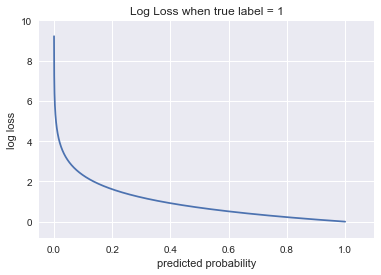

In [44]:
#Visualize Log Loss when True value = 1
#y-axis is log loss, x-axis is probabilty that label = 1
#As you can see Log Loss increases rapidly as we approach 0
#But increases slowly as our predicted probability gets closer to 1
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import log_loss
import seaborn as sns
sns.set()

x = [i*.0001 for i in range(1,10000)]
y = [log_loss([0], [[i*.0001,1-(i*.0001)]], eps=1e-15, labels=[0, 1]) for i in range(1,10000,1)]

plt.plot(x, y)
plt.axis([-.05, 1.1, -.8, 10])
plt.title("Log Loss when true label = 1")
plt.xlabel("predicted probability")
plt.ylabel("log loss")

plt.show()

In [52]:
import scipy
min_logloss = scipy.optimize.minimize_scalar(lambda x: log_loss(expected_labels, our_labels, eps=x), bounds=(1e-10, 0.1), method='bounded')

     fun: 0.090149916078895331
 message: 'Solution found.'
    nfev: 13
  status: 0
 success: True
       x: 0.018002278597942723

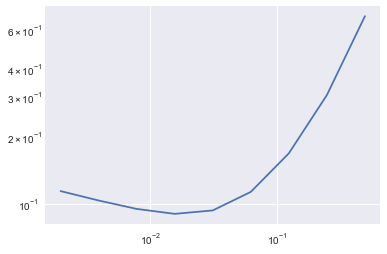

In [54]:
eps_x = [0.5**i for i in range(1,10)]
eps_y = [log_loss(expected_labels, our_labels, eps=eps) for eps in eps_x]
plt.loglog(eps_x, eps_y)
min_logloss

In [55]:
#So to play it safe, we use a sneaky trick to round down our edge predictions
#Swap all ones with .95 and all zeros with .05
eps = min_logloss.x
logloss
isdog = isdog.clip(min=eps, max=1-eps)

In [56]:
#Extract imageIds from the filenames in our test/unknown directory 
filenames = batches.filenames
ids = np.array([int(f[8:f.find('.')]) for f in filenames])

Here we join the two columns into an array of [imageId, isDog]

In [57]:
subm = np.stack([ids,isdog], axis=1)
subm[:5]

array([[  1.0000e+00,   9.8200e-01],
       [  1.0000e+01,   1.8002e-02],
       [  1.0000e+02,   1.8002e-02],
       [  1.0000e+03,   9.8200e-01],
       [  1.0000e+04,   9.8200e-01]])

In [58]:
%cd $DATA_HOME_DIR
submission_file_name = 'submission2.csv'
np.savetxt(submission_file_name, subm, fmt='%d,%.5f', header='id,label', comments='')

C:\Python\AI\data\dogscats


You can download this file and submit on the Kaggle website or use the Kaggle command line tool's "submit" method.

In [61]:
pd.read_csv(submission_file_name, index_col='id')

,label
id,
1,0.98200
10,0.01800
100,0.01800
1000,0.98200
10000,0.98200
10001,0.01800
10002,0.01800
10003,0.98200
10004,0.98200


In [86]:
submission_message = f"VGG16 finetuned from fast.ai lesson1 -- ft2.h5 logloss={min_logloss.fun:.5} eps={eps:.5}"
!kg submit $submission_file_name -m "$submission_message"

0.07828
